In [1]:
import xarray as xr
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from scipy.stats import linregress
from matplotlib.colors import LogNorm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import cmocean
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


settings = json.load(open('../plot_settings.json'))
plt.rcParams.update(settings)


path = '/projekt_agmwend/home_rad/Joshua/Mueller_et_al_2024/data/simulation/sim_out/'
files = [os.path.join(path, f) for f in os.listdir(path) if 'MODIS_SST' in f]
files.sort()

ds = xr.concat([xr.open_dataset(f) for f in files], dim='time')

ds_sim_in = xr.open_dataset('/projekt_agmwend/home_rad/Joshua/Mueller_et_al_2024/data/simulation/surface_temp_sim_input.nc')


ERROR 1: PROJ: proj_create_from_database: Open of /home/jomueller/micromamba/envs/mamba_josh/share/proj failed


In [2]:
BT1 = ds['BT'].isel(channel=0) - 273.15
BT2 = ds['BT'].isel(channel=1) - 273.15
BT3 = ds['BT'].isel(channel=2) - 273.15
BT5 = ds['BT'].isel(channel=3) - 273.15
BT6 = ds['BT'].isel(channel=4) - 273.15

skinT = ds['MODIS_skin_T'] - 273.15

nanmask = ~np.isnan(BT5) & ~np.isnan(skinT)
BT5 = BT5[nanmask]
skinT = skinT[nanmask]


RMSE = <xarray.DataArray ()> Size: 8B
array(2.14613556)
R2 = 0.9620688675142891
N = 12144
MAE: 1.93
MSE: 6.21
RMSE: 2.49
Bias: 0.16


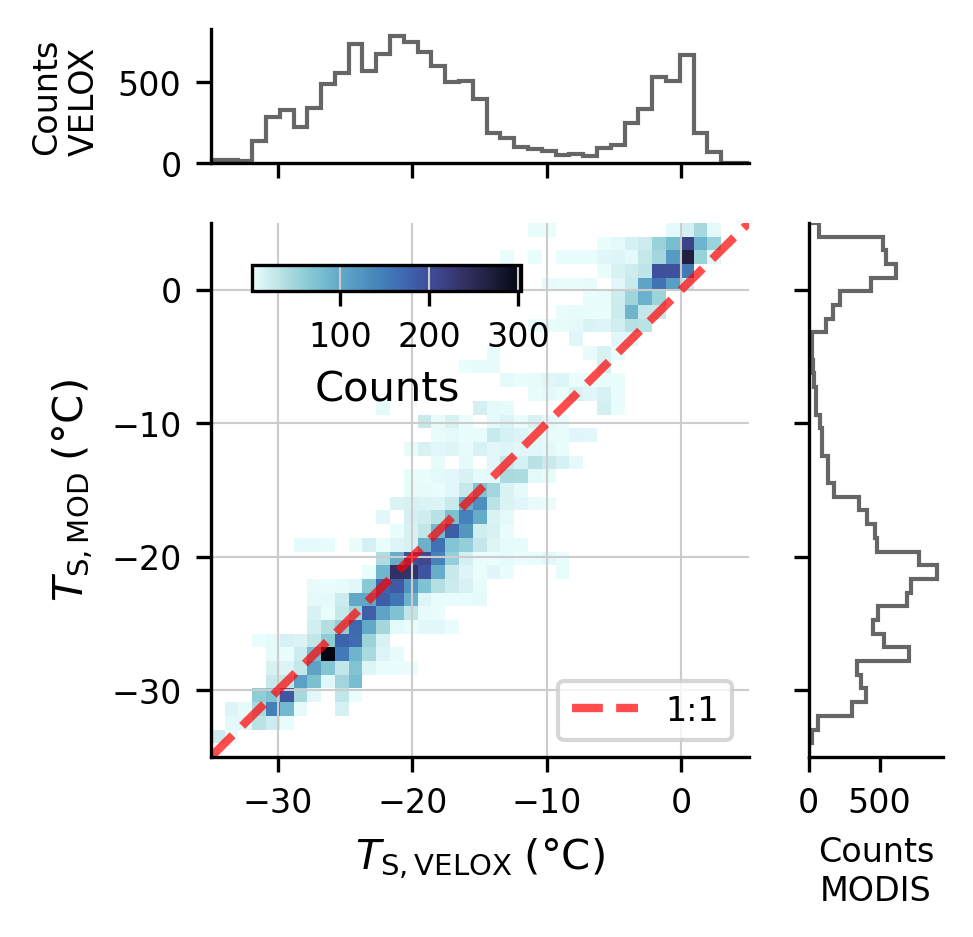

In [3]:
### first, plot all of them together

ylabel = r'$T_\mathrm{S,MOD}\;\mathrm{(°C)}$'
xlabel = r'$T_\mathrm{S,VELOX}\;\mathrm{(°C)}$'

fig, ax = plt.subplots(1, 1, figsize=(3.15, 3.15))

ax.axes.grid(True, zorder=-1)

y = ds_sim_in['MODIS_skin_T'] - 273.15
x = 1.007 * (ds_sim_in['VELOX_skin_T'] - 273.15) + 1.098


dark2_colors = plt.get_cmap('Dark2')(np.linspace(0,1,4))

slope, intercept, r_value, p_value, std_err = linregress(x, y)

new_bins = np.linspace(-35, 5, 40)

#ax.scatter(x, y, s=5, c=dark2_colors[3], edgecolors='k', lw=.3, zorder=1)
im = ax.hist2d(x, y, bins=new_bins, cmap=cmocean.cm.ice_r, zorder=1, cmin=1)

### add histograms to the plot

# ax_histx = ax.inset_axes([0, 1.1, 1, 0.3])
# ax_histy = ax.inset_axes([1.1, 0, 0.3, 1])

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1 import make_axes_locatable

divider = make_axes_locatable(ax)
ax_histx = divider.append_axes("top", "25%", pad=0.2, sharex=ax)
ax_histy = divider.append_axes("right", "25%", pad=0.2, sharey=ax)


ticklabels = [-30, -20, -10, 0]

ax.set_xticks(ticklabels)
ax.set_yticks(ticklabels)


ax_histx.hist(x, bins=new_bins, color=dark2_colors[3], histtype='step')
ax_histy.hist(y, bins=new_bins, orientation='horizontal', color=dark2_colors[3], histtype='step')

ax_histx.set_xlim(ax.get_xlim())
ax_histy.set_ylim(ax.get_ylim())

#ax.plot(x, slope*x + intercept, c='r', lw=2, label=f'linear fit', alpha=0.7, ls='--')
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)

# ax.text(0.05, 0.95, f'N = {len(x)}', transform=ax.transAxes, fontsize=8, ha='left', va='top')
# ax.text(0.05, 0.85, f'R² = {r_value**2:.2f}', transform=ax.transAxes, fontsize=8, ha='left', va='top')

ax_histx.spines[['top', 'right']].set_visible(False)
ax_histy.spines[['top', 'right']].set_visible(False)

ax.spines[['top', 'right']].set_visible(False)

ax_histx.sharex(ax)
ax_histy.sharey(ax)

ax_histx.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=False)
ax_histy.tick_params(axis='y', which='both', left=True, right=False, labelleft=False)

ax_histx.grid(False)
ax_histy.grid(False)

ax_histx.set_ylabel('Counts\nVELOX ', fontsize=8)
ax_histy.set_xlabel('Counts\nMODIS', fontsize=8)

print(f'RMSE = {np.sqrt(np.mean((y - (slope*x + intercept))**2))}')
print(f'R2 = {r_value**2}')
print(f'N = {len(x)}')

ax.axes.grid(True, zorder=-1)

cax = inset_axes(ax, width="50%", height="5%", loc='upper left', borderpad=1)

cbar = plt.colorbar(im[3], cax=cax, orientation='horizontal', label='Counts')

ax.plot([-35,5], [-35, 5], c='r', lw=2, label=f'1:1', alpha=0.7, ls='--')



mae = mean_absolute_error(x, y)
mse = mean_squared_error(x, y)
rmse = np.sqrt(mse)
bias = np.mean(x - y)

print(f'MAE: {mae:.2f}')
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'Bias: {bias:.2f}')


ax.legend(fontsize=8, loc='lower right')

plt.savefig('../../plots/publish/figure08.png', dpi=300, bbox_inches='tight')
